In [46]:
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_scheduler
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
file_path = '/content/drive/MyDrive/cleaned_tweets.csv'

df_csv = pd.read_csv(file_path)
df_csv.info()

label_mapping = {
    "Not Suicide post": 0,
    "Potential Suicide post ": 1
}

df_csv_cleaned = df_csv.dropna(subset=['Cleaned_Tweet'])

df_csv_cleaned['Suicide'] = df_csv_cleaned['Suicide'].map(label_mapping)

sentence_lengths = df_csv_cleaned['Cleaned_Tweet'].apply(lambda x: len(x.split()))
average_length = sentence_lengths.mean()
max_length = sentence_lengths.max()

print(f"Average sentence length: {average_length}")
print(f"Maximum sentence length: {max_length}")
df_csv_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Cleaned_Tweet  1784 non-null   object
 1   Suicide        1787 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB
Average sentence length: 11.695627802690582
Maximum sentence length: 142
<class 'pandas.core.frame.DataFrame'>
Index: 1784 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Cleaned_Tweet  1784 non-null   object
 1   Suicide        1784 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 41.8+ KB


<ipython-input-27-cd058b4bf93f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv_cleaned['Suicide'] = df_csv_cleaned['Suicide'].map(label_mapping)


In [28]:
# Controllare la disponibilità della GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
# Inizializzare il tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_LEN = 40
# Dataset personalizzato
class SuicideTweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenizzare il testo con encode_plus
        encodings = tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,  # Aggiunge [CLS] e [SEP]
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        # Preparare il dizionario degli input per il DataLoader
        item = {
            'input_ids': encodings['input_ids'].squeeze(0),
            'attention_mask': encodings['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

# Creare il dataset
dataset = SuicideTweetDataset(
    texts=df_csv_cleaned["Cleaned_Tweet"].tolist(),
    labels=df_csv_cleaned["Suicide"].tolist()
)

In [50]:
# Funzione per mostrare i token e i loro ID con delimitatori
def display_token_example_with_delimiters(dataset, idx=0):
    # Estrai i dati dal dataset personalizzato
    sample = dataset[idx]

    # Ottieni gli ID dei token
    token_ids = sample['input_ids'].tolist()

    # Convertire gli ID dei token in token leggibili
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    # Creare la tabella dei token
    token_table = pd.DataFrame({
        "Tokens": tokens,
        "Token IDs": token_ids
    })

    # Formattare la tabella con delimitatori
    print(tabulate(token_table, headers='keys', tablefmt='grid'))

# Mostrare i token e gli ID per la prima frase del dataset
display_token_example_with_delimiters(dataset, idx=500)

+----+----------+-------------+
|    | Tokens   |   Token IDs |
+====+==========+=============+
|  0 | [CLS]    |         101 |
+----+----------+-------------+
|  1 | nearly   |        3053 |
+----+----------+-------------+
|  2 | holidays |       11938 |
+----+----------+-------------+
|  3 | hand     |        2192 |
+----+----------+-------------+
|  4 | camping  |       13215 |
+----+----------+-------------+
|  5 | [SEP]    |         102 |
+----+----------+-------------+
|  6 | [PAD]    |           0 |
+----+----------+-------------+
|  7 | [PAD]    |           0 |
+----+----------+-------------+
|  8 | [PAD]    |           0 |
+----+----------+-------------+
|  9 | [PAD]    |           0 |
+----+----------+-------------+
| 10 | [PAD]    |           0 |
+----+----------+-------------+
| 11 | [PAD]    |           0 |
+----+----------+-------------+
| 12 | [PAD]    |           0 |
+----+----------+-------------+
| 13 | [PAD]    |           0 |
+----+----------+-------------+
| 14 | [

In [30]:
# Dividere il dataset in training e validation set
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creare i DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [31]:
# Inizializzare il modello pre-addestrato BERT con un livello di classificazione
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
# Ottimizzatore AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

# Scheduler per il tasso di apprendimento
num_training_steps = len(train_loader) * 3  # 3 epoche
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
def plot_training_validation_loss(results_df):
    # Estrarre i dati dal DataFrame
    epochs = range(1, len(results_df) + 1)
    training_loss = results_df["Training Loss"]
    validation_loss = results_df["Valid. Loss"]

    # Creare il grafico
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, training_loss, marker='o', label="Training")
    plt.plot(epochs, validation_loss, marker='o', label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [39]:
def plot_confusion_matrices(model, val_loader):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].cpu().numpy()
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, axis=-1).cpu().numpy()

            y_true.extend(labels)
            y_pred.extend(predictions)

    # Matrice di confusione effettiva
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Grafico della matrice effettiva
    plt.figure(figsize=(8, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Suicide', 'Potential Suicide'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix (Effettiva)")
    plt.show()

    # Grafico della matrice in percentuale
    plt.figure(figsize=(8, 5))
    disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Not Suicide', 'Potential Suicide'])
    disp_percent.plot(cmap='Blues', values_format=".2f")
    plt.title("Confusion Matrix (Percentuale)")
    plt.show()

In [34]:
def train_model(model, train_loader, val_loader, epochs=2):
    loss_fn = torch.nn.CrossEntropyLoss()
    results = []  # Per registrare i risultati di ogni epoca

    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, leave=True)
        total_loss = 0
        start_time = time.time()

        for batch in loop:
            # Spostare i dati sulla GPU (se disponibile)
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

            # Backpropagazione
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()

            # Aggiornare il loop di progressione
            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item())

        # Calcolare la media del training loss
        avg_training_loss = total_loss / len(train_loader)

        # Valutazione sulle validation data
        val_loss, val_accuracy = evaluate_model(model, val_loader)

        # Calcolare il tempo di addestramento
        epoch_time = time.time() - start_time

        # Registrare i risultati
        results.append({
            "Epoche": f"Epoca {epoch + 1}",
            "Training Loss": round(avg_training_loss, 2),
            "Valid. Loss": round(val_loss, 2),
            "Valid. Accur.": round(val_accuracy, 2),
            "Training Time": time.strftime("%H:%M:%S", time.gmtime(epoch_time))
        })

    # Creare e visualizzare la tabella
    results_df = pd.DataFrame(results)
    print(results_df)

    # Generare il grafico
    plot_training_validation_loss(results_df)

    return results_df

def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    # Calcolare la valid loss e la valid accuracy
    avg_val_loss = total_loss / len(val_loader)
    accuracy = correct / total
    return avg_val_loss, accuracy

Epoch 3: 100%|██████████| 90/90 [00:12<00:00,  7.09it/s, loss=0.00657]


    Epoche  Training Loss  Valid. Loss  Valid. Accur. Training Time
0  Epoca 1           0.31         0.37           0.89      00:00:13
1  Epoca 2           0.13         0.34           0.90      00:00:13
2  Epoca 3           0.05         0.27           0.92      00:00:13


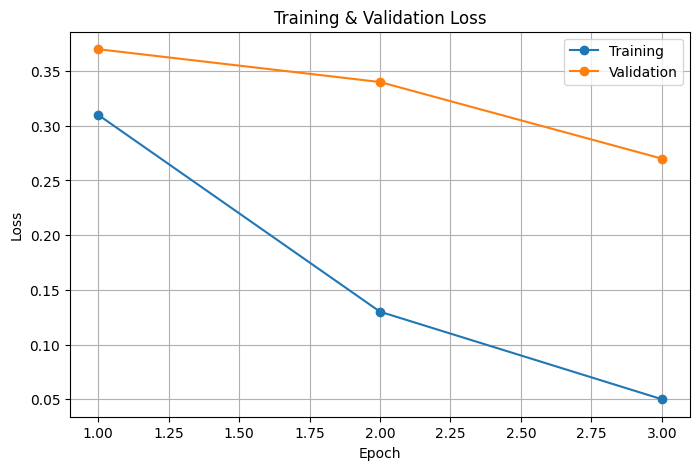

,Epoche,Training Loss,Valid. Loss,Valid. Accur.,Training Time
0,Epoca 1,0.31,0.37,0.89,00:00:13
1,Epoca 2,0.13,0.34,0.90,00:00:13
2,Epoca 3,0.05,0.27,0.92,00:00:13


In [35]:
train_model(model, train_loader, val_loader, epochs=3)

<Figure size 800x500 with 0 Axes>

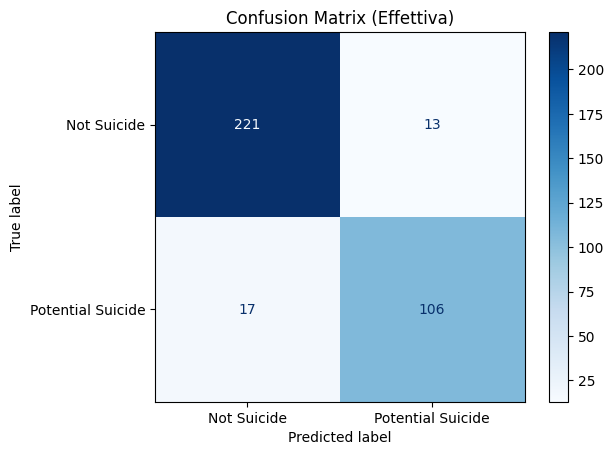

<Figure size 800x500 with 0 Axes>

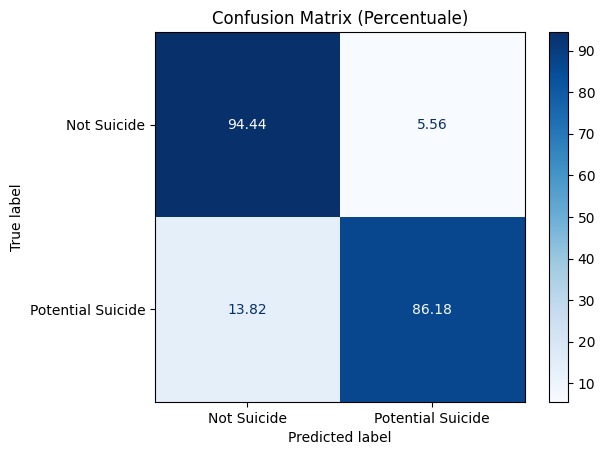

In [40]:
plot_confusion_matrices(model, val_loader)